# Tutorial - Step5 : MTMR evaluation by comparing to SOTA models

## 1. Import requirements

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from MTMR.evaluate import evaluate_metric

## 2. Specify a target property

In [3]:
PROPERTY_NAME = "drd2"

## 3. Set directories (for inputs and outputs)

In [4]:
input_data_dir = os.path.join("DATA", PROPERTY_NAME)
input_our_dir = os.path.join("outputs_Tutorial_4_MTMR_translation", PROPERTY_NAME)
input_base_dir = os.path.join("DATA", "baselines")

In [5]:
_output_dir = "outputs_Tutorial_5_MTMR_evaluation"
if not os.path.exists(_output_dir):
    os.mkdir(_output_dir)

output_dir = os.path.join(_output_dir, PROPERTY_NAME)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 4. Set file names

In [6]:
filepath_train_rdkit = os.path.join(input_data_dir, "rdkit_train_pairs.txt")
filepath_train = os.path.join(input_base_dir, f"train_pairs_{PROPERTY_NAME.upper()}.txt")

In [7]:
df_pairs_rdkit = pd.read_csv(filepath_train_rdkit, header=None, sep=" ")
df_pairs = pd.read_csv(filepath_train, header=None, sep=" ")
targets_rdkit = set(df_pairs_rdkit.iloc[:,1].values.tolist())
targets = set(df_pairs.iloc[:,1].values.tolist())

In [8]:
filepath_MTMR  = os.path.join(input_our_dir, f"MTMR_{PROPERTY_NAME.upper()}.csv")
#filepath_JTVAE = os.path.join(input_base_dir, f"JTVAE_{PROPERTY_NAME.upper()}.csv")
filepath_G2G   = os.path.join(input_base_dir, f"VJTNN_{PROPERTY_NAME.upper()}.csv")
#filepath_CORE  = os.path.join(input_base_dir, f"CORE_{PROPERTY_NAME.upper()}.csv")
#filepath_MOLCG = os.path.join(input_base_dir, f"MOLCG_{PROPERTY_NAME.upper()}.csv")
filepath_UGMMT = os.path.join(input_base_dir, f"UGMMT_{PROPERTY_NAME.upper()}.csv")

## 5. Load translation results generated from the test dataset

In [9]:
df_MTMR  = pd.read_csv(filepath_MTMR, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
#df_JTVAE = pd.read_csv(filepath_JTVAE, header=None).fillna("")
df_G2G   = pd.read_csv(filepath_G2G, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
#df_CORE  = pd.read_csv(filepath_CORE, header=None).fillna("")
#df_MOLCG = pd.read_csv(filepath_MOLCG, header=None).fillna("")
df_UGMMT = pd.read_csv(filepath_UGMMT, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})

## 6. Evaluate metrics

In [10]:
df_metric_MTMR  = evaluate_metric(df_MTMR, targets_rdkit, num_decode=20, threshold_sim=0.4, threshold_pro=0.5).rename(columns={0:"MTMR"})
#df_metric_JTVAE = evaluate_metric(df_JTVAE, targets, SCORING_FT, threshold_sim=0.4, threshold_pro=0.5).rename(columns={0:"JTVAE"})
df_metric_G2G   = evaluate_metric(df_G2G, targets_rdkit, num_decode=20, threshold_sim=0.4, threshold_pro=0.5).rename(columns={0:"G2G"})
#df_metric_CORE  = evaluate_metric(df_CORE, targets, SCORING_FT, threshold_sim=0.4, threshold_pro=0.5).rename(columns={0:"CORE"})
#df_metric_MOLCG = evaluate_metric(df_MOLCG, targets, SCORING_FT, threshold_sim=0.4, threshold_pro=0.5).rename(columns={0:"MOLCG"})
df_metric_UGMMT = evaluate_metric(df_UGMMT, targets_rdkit, num_decode=20, threshold_sim=0.4, threshold_pro=0.5).rename(columns={0:"UGMMT"})

In [12]:
df_merged = pd.concat([df_metric_MTMR,
                       df_metric_UGMMT,
                       #df_metric_MOLCG,
                       #df_metric_CORE,
                       #df_metric_JTVAE,
                       df_metric_G2G], axis=1).T

In [13]:
df_merged

,VALID_RATIO,AVERAGE_PROPERTY,AVERAGE_SIMILARITY,NOVELTY,SUCCESS,SUCCESS_WO_NOVEL,DIVERSITY
MTMR,1.000,0.799259,0.329498,0.999,0.434,0.439,8.814
UGMMT,0.999,0.737127,0.261423,0.996,0.173,0.205,13.895
G2G,0.999,0.803339,0.343539,0.696,0.121,0.696,2.596


In [14]:
df_merged.to_csv(os.path.join(output_dir, "table_metrics.csv"))

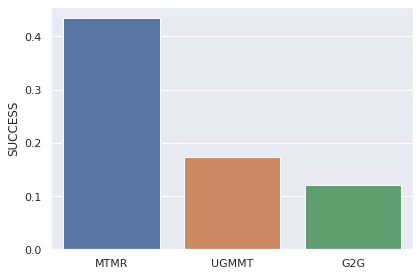

In [15]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1)
sns.barplot(x=df_merged.index, y=df_merged["SUCCESS"], ax=ax)

plt.tight_layout()
#plt.savefig(os.path.join(output_dir, "barplot_success.png"), dpi=300)